In [1]:
import pandas as pd
import itertools
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# Test system simulations - define a 5 dimensional function with random noise, and generate all possible combinations of input parameters

In [2]:
## Define a complex, 5 dimensional function with a bit of random noise
def f(a,b,c,d,e):
    y = np.sin(a) * np.cos(-b) * np.exp(-c**2) * (d*1.1) + e**2 + np.random.uniform(-0.1, 0.1)
    return(y)

In [3]:
params = {"a" : range(0,6, 1),
"b" : range(0,6, 1),
"c" : range(0,6, 1),
"d" : range(0,6, 1),
"e" : range(0,6, 1)}

keys = list(params)

x_values = []
y_values = []

for values in itertools.product(*map(params.get, keys)):
    y = f(**dict(zip(keys, values)))

    x_values.append(values)
    y_values.append(y)


In [4]:
truemin = np.array(y_values).min()

In [5]:
truemin

-5.335284877125038

## Figure 4b - Random vs Kmeans seed selection

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [10]:
## Set up the state space
state_space = pd.concat([pd.DataFrame(x_values), pd.DataFrame(y_values)], axis =1)
state_space.columns = ['a', 'b', 'c', 'd', 'e', 'Y']

In [11]:
## Define a function for fitting a GPR and returning the MAE, MSE, and R2 scores
def fit_GPR(sample):
    ## Get X and Y
    X = sample.drop("Y", axis =1)
    y = sample["Y"]
    ## Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    ## Fit model
    gpr = GaussianProcessRegressor()
    gpr.fit(X_train, y_train)
    ## Make predictions
    y_pred, y_std = gpr.predict(X_test, return_std=True)

    ## Return MAE MSE and R2
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return(mae, mse, r2)

In [12]:
## Randomly sample from the dataframe and fit a GPR 1000 times
random_sample_stats = []
for s in range(0,1000):
    sample = state_space.sample(96)
    random_sample_stats.append(fit_GPR(sample))

random_df = pd.DataFrame(random_sample_stats, columns=["random_MAE", "random_MSE", "random_R2"])

In [12]:
#random_df.to_csv("Random_sampling_scores.csv") ## Save the scores

In [13]:
random_df.mean()

random_MAE     6.552274
random_MSE    96.219215
random_R2     -0.237308
dtype: float64

In [14]:
## Use kmeans to sample from the dataframe
kmeans_sample_stats = []
for s in range(0,1000):
    if s %20 == 0:
        print(s)
    kmeans = KMeans(n_clusters=96, n_init = 10)
    kmeans.fit(state_space)

    # Get cluster centers
    centers = kmeans.cluster_centers_
    closest, distances = pairwise_distances_argmin_min(centers, state_space)
    rows_nearest_centers = state_space.iloc[closest]
    kmeans_sample_stats.append(fit_GPR(rows_nearest_centers))

kmeans_df = pd.DataFrame(kmeans_sample_stats, columns=["kmeans_MAE", "kmeans_MSE", "kmeans_R2"])

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980


In [15]:
#kmeans_df.to_csv("Kmeans_sampling_scores.csv") ## Save the scores

In [15]:
kmeans_df.mean()

kmeans_MAE     5.080677
kmeans_MSE    69.308246
kmeans_R2      0.140237
dtype: float64

In [16]:
state_space_drop = state_space.drop("Y", axis =1).values

In [17]:
combined = pd.concat([random_df, kmeans_df], axis =1)

In [18]:
combined

,random_MAE,random_MSE,random_R2,kmeans_MAE,kmeans_MSE,kmeans_R2
0,9.098826,153.645878,-0.682752,3.694586,45.742267,0.306253
1,4.699629,33.833342,0.195953,4.716293,61.255559,0.251996
2,7.533462,121.616704,-0.723682,7.167043,113.870652,-0.406563
3,7.334869,116.311963,-0.464781,7.920172,111.299493,-0.123508
4,8.097105,138.084308,-0.529164,5.327147,76.462621,-0.093047
...,...,...,...,...,...,...
995,8.485983,136.276959,-0.347116,4.671052,60.106289,0.248591
996,7.889060,130.302180,-0.413747,2.929388,26.040285,0.539768
997,7.772734,122.747041,-0.422702,6.743594,90.632260,-0.035893
998,8.895578,146.313649,-0.651291,7.315594,119.944135,-0.249923


In [19]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [4, 5]

from scipy import stats
import scipy

In [20]:
scipy.stats.ttest_ind(combined["kmeans_MSE"].dropna().tolist(), combined["random_MSE"].dropna().tolist())

TtestResult(statistic=-21.286917800937278, pvalue=8.602165173209052e-91, df=1998.0)

/var/folders/vv/0521912d5_j4wpw2lwprbrzw0000gn/T/ipykernel_45126/1542363647.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_yticklabels([0, 50, 100, 150, 200, 250, 300], size = 14)
/var/folders/vv/0521912d5_j4wpw2lwprbrzw0000gn/T/ipykernel_45126/1542363647.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(["Random", "Kmeans"], size = 14)


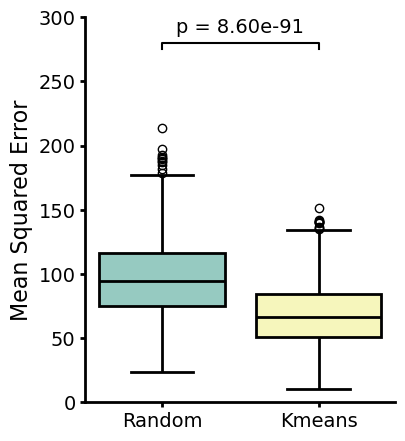

In [24]:
g = sns.boxplot(combined[["random_MSE", "kmeans_MSE"]], palette = "Set3", linecolor = "k", linewidth = 2)
#g = sns.swarmplot(combined[["random_MSE", "kmeans_MSE"]], palette ="Set3", edgecolor = "k", linewidth =1,  size = 6)

g.set_ylim(0,300)
g.set_yticklabels([0, 50, 100, 150, 200, 250, 300], size = 14)
g.set_ylabel("Mean Squared Error", size = 16)
g.set_xticklabels(["Random", "Kmeans"], size = 14)

plt.setp(g.spines.values(), linewidth=2)
g.tick_params(width=2)

x1, x2 = 0, 1   
y, h, col = 260 + 15, 5, 'k'

plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+2*h, "p = 8.60e-91", ha='center', va='bottom', color=col, size = 14)

sns.despine()


## Simulate a random vs bayesian approach - Figures 4c, d, e

In [25]:
import GPyOpt
import matplotlib.patches as mpatches


In [26]:
## Random Approach

mins = []
number_lowsamples = []
for run in range(0,1000):
    min_vals = []
    low_samples = []
    starting_sample = state_space.sample(96)
    min_value = starting_sample["Y"].min()
    min_vals.append(min_value)
    low_samples.append((starting_sample["Y"] < np.percentile(y_values,0.05)).sum())
    

    current_sample_space = state_space.drop(starting_sample.index)
    current_samples = starting_sample.copy()
    for loop in range(0,5):
        sample = current_sample_space.sample(32)
        current_samples = pd.concat([current_samples, sample],axis =0)
        current_sample_space = current_sample_space.drop(sample.index)

        min_value = current_samples["Y"].min()
        min_vals.append(min_value)
        low_samples.append((current_samples["Y"] < np.percentile(y_values,0.01)).sum())

    mins.append(min_vals)
    number_lowsamples.append(low_samples)

In [27]:
mins_random = pd.DataFrame(mins)
number_lowsamples_df = pd.DataFrame(number_lowsamples)

In [28]:
mins_random = pd.melt(mins_random)
number_random = pd.melt(number_lowsamples_df)

In [30]:
domain =[{'name': 'a', 'type': 'discrete', 'domain': (0,1,2,3,4,5)},
        {'name': 'b', 'type': 'discrete', 'domain': (0,1,2,3,4,5)},
        {'name': 'c', 'type': 'discrete', 'domain': (0,1,2,3,4,5)},
        {'name': 'd', 'type': 'discrete', 'domain': (0,1,2,3,4,5)},
        {'name': 'e', 'type': 'discrete', 'domain': (0,1,2,3,4,5)}]


In [58]:
mins_BO = []
samples_BO = []

for run in range(0,1000):
    print("Run " + str(run))
    iter_count = 5

    current_iter = 1

    min_vals = []
    low_samples = []
    
    kmeans = KMeans(n_clusters=96, n_init = 10)
    kmeans.fit(state_space)



    # Get cluster centers
    centers = kmeans.cluster_centers_
    closest, _ = pairwise_distances_argmin_min(centers, state_space)
    starting_samples = state_space.iloc[closest].drop("Y", axis =1).values
    starting_Y = state_space.iloc[closest]["Y"].values
    
    min_vals.append(starting_Y.min())
    low_samples.append((starting_Y < np.percentile(y_values,0.01)).sum())
    
    starting_Y = starting_Y.reshape(len(starting_Y), 1)

    available_samples = state_space.drop(starting_sample.index)

    bo_step = GPyOpt.methods.BayesianOptimization(f = None, domain = domain, X = starting_samples, Y = starting_Y, acquisition_type='EI'
                                             ,evaluator_type="thompson_sampling", batch_size=32, de_duplication=True)

    x_next = bo_step.suggest_next_locations().astype(int)
    y_next = np.apply_along_axis(lambda row: f(*row), axis=1, arr=x_next)

    X_step = np.vstack((starting_samples, x_next))
    Y_step = np.vstack((starting_Y, y_next.reshape(len(y_next),1)))
    min_vals.append(Y_step.min())
    low_samples.append((Y_step < np.percentile(y_values,0.01)).sum())

    
    while current_iter < iter_count:
        bo_step = GPyOpt.methods.BayesianOptimization(f = None, domain = domain, X = X_step, Y = Y_step, acquisition_type='EI'
                                             ,evaluator_type="thompson_sampling", batch_size=32, de_duplication=True)

        x_next = bo_step.suggest_next_locations().astype(int)
        y_next = np.apply_along_axis(lambda row: f(*row), axis=1, arr=x_next)
    
        X_step = np.vstack((X_step, x_next))
        Y_step = np.vstack((Y_step, y_next.reshape(len(y_next),1)))
        min_vals.append(Y_step.min())
        low_samples.append((Y_step < np.percentile(y_values,0.01)).sum())
        current_iter += 1
    mins_BO.append(min_vals)
    samples_BO.append(low_samples)

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Run 11
Run 12
Run 13
Run 14
Run 15
Run 16
Run 17
Run 18
Run 19
Run 20
Run 21
Run 22
Run 23
Run 24
Run 25
Run 26
Run 27
Run 28
Run 29
Run 30
Run 31
Run 32
Run 33
Run 34
Run 35
Run 36
Run 37
Run 38
Run 39
Run 40
Run 41
Run 42
Run 43
Run 44
Run 45
Run 46
Run 47
Run 48
Run 49
Run 50
Run 51
Run 52
Run 53
Run 54
Run 55
Run 56
Run 57
Run 58
Run 59
Run 60
Run 61
Run 62
Run 63
Run 64
Run 65
Run 66
Run 67
Run 68
Run 69
Run 70
Run 71
Run 72
Run 73
Run 74
Run 75
Run 76
Run 77
Run 78
Run 79
Run 80
Run 81
Run 82
Run 83
Run 84
Run 85
Run 86
Run 87
Run 88
Run 89
Run 90
Run 91
Run 92
Run 93
Run 94
Run 95
Run 96
Run 97
Run 98
Run 99
Run 100
Run 101
Run 102
Run 103
Run 104
Run 105
Run 106
Run 107
Run 108
Run 109
Run 110
Run 111
Run 112
Run 113
Run 114
Run 115
Run 116
Run 117
Run 118
Run 119
Run 120
Run 121
Run 122
Run 123
Run 124
Run 125
Run 126
Run 127
Run 128
Run 129
Run 130
Run 131
Run 132
Run 133
Run 134
Run 135
Run 136
Run 137
Run 13

In [59]:
mins_BO = pd.DataFrame(mins_BO)
number_lowsamples_BO = pd.DataFrame(samples_BO)

melted_mins_BO = mins_BO.melt()
melted_number_lowsamples_BO = number_lowsamples_BO.melt()

### Figure 4c

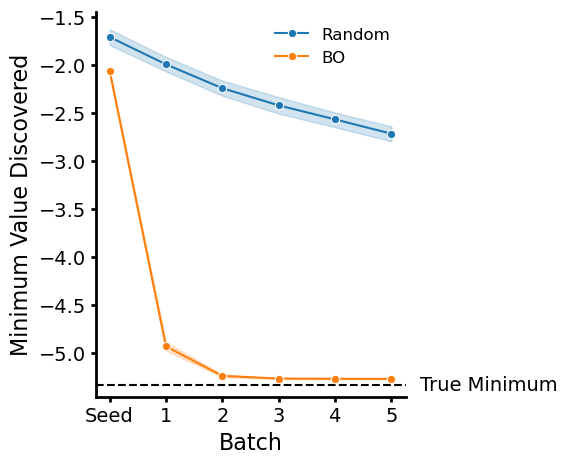

In [60]:
g= sns.lineplot(mins_random, x = "variable", y = "value", marker = "o", label = "Random")
g2 = sns.lineplot(melted_mins_BO, x = "variable", y = "value", marker = "o", label = "BO")

g.set_yticklabels(g.get_yticklabels(), size = 14)
g.set_ylabel("Minimum Value Discovered", size = 16)
g.set_xticklabels([0, "Seed", 1,2,3,4,5], size = 14)
g.set_xlabel("Batch", size = 16)

plt.setp(g.spines.values(), linewidth=2)
g.tick_params(width=2)

g.axhline(truemin, c = "k", ls = "--")
g.annotate("True Minimum", (5.5, truemin), annotation_clip = False, va = "center", size = 14)

g.legend(fontsize = 12, frameon = False)

sns.despine()

plt.savefig("BO_vs_Random_minvalue_1000.pdf", bbox_inches = "tight")

### Figure 4d

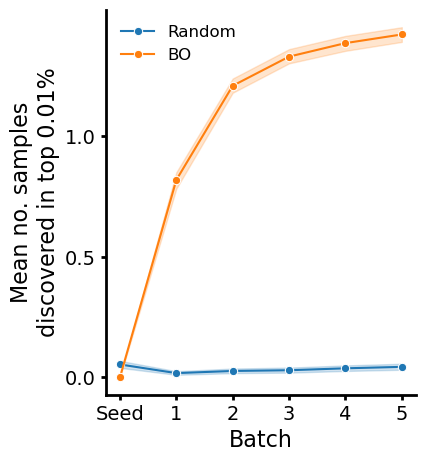

In [61]:
g = sns.lineplot(number_random, x = "variable", y = "value", marker = "o", label = "Random")
g2 = sns.lineplot(melted_number_lowsamples_BO, x = "variable", y = "value", marker = "o", label = "BO")

g.set_yticks([0, 0.5, 1])
g.set_yticklabels(g.get_yticklabels(), size = 14)
g.set_ylabel("Mean no. samples\ndiscovered in top 0.01%", size = 16)
g.set_xticklabels([0, "Seed", 1,2,3,4,5], size = 14)
g.set_xlabel("Batch", size = 16)

plt.setp(g.spines.values(), linewidth=2)
g.tick_params(width=2)

g.legend(fontsize = 12, frameon = False)

sns.despine()

plt.savefig("BO_vs_Random_numberdiscovered_1000.pdf", bbox_inches = "tight")

# Figure 4e - performing post-hoc BO on our collected dataset

In [62]:
import numpy as np
import pandas as pd
import GPyOpt
from GPyOpt.methods import BayesianOptimization

In [63]:
collected_data = pd.read_csv("../data/master_results.csv")

# Get only columns with data + measure to be optimised
collected_data_short = collected_data[["T20", "T80", "P188", "DMSO", "PG", "Mean Absorbance"]]

# Switch sign of absorbance
collected_data_short["Mean Absorbance"] = collected_data_short["Mean Absorbance"]

In [64]:
# Define the domain
candidates = collected_data_short[['T20', 'T80', 'P188', 'DMSO', 'PG']].values

#### Set up the system

In [65]:
# Find the true minimum
true_min_value = collected_data_short['Mean Absorbance'].min()
true_min_location = collected_data_short[['T20', 'T80', 'P188', 'DMSO', 'PG']].iloc[collected_data_short['Mean Absorbance'].idxmin()].values

In [66]:
## Function to get the lowest value sample from the dataset

def get_lowest_value_sample(targets):
    """
    Return the index and value of the lowest (minimum) target in the given array.
    """
    lowest_index = np.argmin(targets)
    lowest_value = targets[lowest_index]
    return lowest_index, lowest_value

#### Random sampling

In [67]:
def random_sampling_until_optimum(samples, targets, max_iterations=10000):
    ## Randomly sample from the list of samples until the optimum is found

    # Identify the absolute best sample and its index
    absolute_best_index, absolute_best_value = get_lowest_value_sample(targets)

    # Keep track of which samples have been evaluated
    evaluated_samples = set()
    num_evaluated = 0

    for iteration in range(max_iterations):
        # Randomly pick a sample that has not been evaluated yet
        possible_indices = np.setdiff1d(np.arange(len(samples)), list(evaluated_samples))
        if len(possible_indices) == 0:
            print("All samples have been evaluated, but the best sample wasn't found (unexpected).")
            break

        chosen_index = np.random.choice(possible_indices)
        evaluated_samples.add(chosen_index)
        num_evaluated += 1

        # Check if this is the absolute best sample
        if chosen_index == absolute_best_index:
            print(f"Found the best sample at index {chosen_index} with target {absolute_best_value}.")
            break
    else:
        # If we exhaust max_iterations without finding the best sample
        print(f"Did not find the best sample within {max_iterations} iterations.")
    
    return num_evaluated


In [68]:
## Define the samples and values
samples = collected_data_short[["T20", "T80", "P188", "DMSO", "PG"]].values
targets = collected_data_short["Mean Absorbance"].values

n_repeats = 1000
random_sample_counts = []

# Perform the sampling 100 times
for _ in range(n_repeats):
    number_samples_random = random_sampling_until_optimum(samples, targets)
    print("Number of samples evaluated (random):", number_samples_random)
    random_sample_counts.append(number_samples_random)

Found the best sample at index 13 with target 0.0267.
Number of samples evaluated (random): 161
Found the best sample at index 13 with target 0.0267.
Number of samples evaluated (random): 44
Found the best sample at index 13 with target 0.0267.
Number of samples evaluated (random): 200
Found the best sample at index 13 with target 0.0267.
Number of samples evaluated (random): 246
Found the best sample at index 13 with target 0.0267.
Number of samples evaluated (random): 176
Found the best sample at index 13 with target 0.0267.
Number of samples evaluated (random): 218
Found the best sample at index 13 with target 0.0267.
Number of samples evaluated (random): 66
Found the best sample at index 13 with target 0.0267.
Number of samples evaluated (random): 239
Found the best sample at index 13 with target 0.0267.
Number of samples evaluated (random): 28
Found the best sample at index 13 with target 0.0267.
Number of samples evaluated (random): 27
Found the best sample at index 13 with targe

#### Bayesian Optimisation

In [69]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm

## Set up system
samples = collected_data_short[["T20", "T80", "P188", "DMSO", "PG"]].values
targets = collected_data_short["Mean Absorbance"].values

# Scale inputs and outputs
X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_scaled = X_scaler.fit_transform(samples)
y_scaled = y_scaler.fit_transform(targets.reshape(-1, 1)).ravel()

In [70]:
## Functions to run the optimsiation

# Get the lowest sample 
def get_lowest_value_sample(y):
    min_idx = np.argmin(y)
    return min_idx, y[min_idx]

# Expected improvement
def expected_improvement(x, gp, X_sample, y_sample, xi=0.01):
    x = np.array(x).reshape(1, -1)
    mu, sigma = gp.predict(x, return_std=True)
    mu = mu.flatten()
    sigma = sigma.flatten()

    f_best = np.min(y_sample)
    improvement = f_best - mu - xi
    improvement = np.maximum(improvement, 0)

    # Avoid division by zero
    sigma = np.where(sigma == 0, 1e-10, sigma)
    Z = improvement / sigma
    ei = improvement * norm.cdf(Z) + sigma * norm.pdf(Z)
    return ei[0]

# Run an iteration of the bayesian optimisation
def bayesian_optimization_iteration(X_scaled, y_scaled, evaluated_indices, gp, xi=0.01):
    # Fit the GP on evaluated samples
    gp.fit(X_scaled[evaluated_indices], y_scaled[evaluated_indices])

    best_acq = -float('inf')
    best_idx = None

    for idx in range(len(X_scaled)):
        if idx in evaluated_indices:
            continue
        ei_value = expected_improvement(X_scaled[idx], gp, X_scaled[evaluated_indices], y_scaled[evaluated_indices], xi=xi)
        if ei_value > best_acq:
            best_acq = ei_value
            best_idx = idx

    return best_idx

# Run a full BO until the best sample is found
def run_bo(X_scaled, y_scaled, max_iterations=10000):
    # Determine the absolute best sample from the entire dataset
    absolute_best_idx, absolute_best_value = get_lowest_value_sample(y_scaled)

    # Set up the GP
    kernel = ConstantKernel(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=1.5)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, alpha=1e-6, normalize_y=False)

    # Start with 5 random samples
    evaluated_indices = list(np.random.choice(len(X_scaled), size=5, replace=False))
    
    # Keep track of how many samples we evaluate
    # 5 are initially evaluated
    for i in range(5, max_iterations):
        # Check if we already hit the best sample in our initial random selection
        if absolute_best_idx in evaluated_indices:
            # Already found the best sample
            return len(evaluated_indices)

        next_idx = bayesian_optimization_iteration(X_scaled, y_scaled, evaluated_indices, gp, xi=0.01)
        if next_idx is None:
            # No improvement found - but we haven't found best sample; we might just end here
            return len(evaluated_indices)

        evaluated_indices.append(next_idx)
        
        # Check if we found the best sample
        if next_idx == absolute_best_idx:
            return len(evaluated_indices)
    
    # If we reach max_iterations without finding the best sample, just return how many we evaluated
    return len(evaluated_indices)

In [71]:
# Run the BO 1000 times and store results
results = []
for run in range(1000):
    print("Run " + str(run))
    samples_found = run_bo(X_scaled, y_scaled)
    print(samples_found)
    results.append(samples_found)

print("Results of 1000 runs (number of samples evaluated until best found):")
print(results)

Run 0
41
Run 1
123
Run 2
34
Run 3
41
Run 4
43
Run 5
24
Run 6
20
Run 7
22
Run 8
8
Run 9
30
Run 10
5
Run 11
41
Run 12
20
Run 13
13
Run 14
36
Run 15
39
Run 16
11
Run 17
33
Run 18
47
Run 19
116
Run 20
6
Run 21
36
Run 22
34
Run 23
37
Run 24
13
Run 25
121
Run 26
36
Run 27
117
Run 28
45
Run 29
22
Run 30
5
Run 31
43
Run 32
5
Run 33
42
Run 34
10
Run 35
5
Run 36
16
Run 37
35
Run 38
44
Run 39
37
Run 40
36
Run 41
7
Run 42
117
Run 43
7
Run 44
20
Run 45
7
Run 46
26
Run 47
117
Run 48
17
Run 49
112
Run 50
31
Run 51
118
Run 52
43
Run 53
37
Run 54
30
Run 55
38
Run 56
38
Run 57
33
Run 58
23
Run 59
38
Run 60
20
Run 61
32
Run 62
120
Run 63
45
Run 64
26
Run 65
34
Run 66
15
Run 67
32
Run 68
36
Run 69
36
Run 70
52
Run 71
37
Run 72
25
Run 73
6
Run 74
18
Run 75
9
Run 76
28
Run 77
9
Run 78
55
Run 79
22
Run 80
20
Run 81
5
Run 82
123
Run 83
40
Run 84
34
Run 85
42
Run 86
42
Run 87
7
Run 88
8
Run 89
35
Run 90
18
Run 91
34
Run 92
28
Run 93
37
Run 94
46
Run 95
35
Run 96
36
Run 97
56
Run 98
5
Run 99
41
Run 100
33
Run 1

In [74]:
combined_data = pd.DataFrame({
    'Values':  random_sample_counts + results,
    'Category': ['Random'] * len(random_sample_counts) + ['Bayesian\nOptimisation'] * len(results) 
})

In [75]:
scipy.stats.ttest_ind(results, random_sample_counts)

TtestResult(statistic=-34.348653662249205, pvalue=1.3574814815965033e-203, df=1998.0)

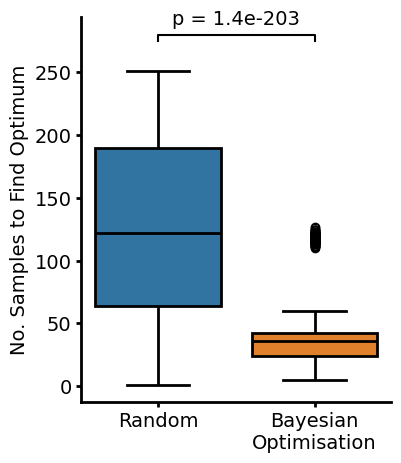

In [77]:
g= sns.boxplot(x='Category', y='Values', data=combined_data, palette = sns.color_palette(), linecolor = "k", linewidth = 2)

# Add titles and labels
plt.ylabel('No. Samples to Find Optimum', size = 14)

g.set_yticklabels(g.get_yticklabels(), size = 14)
g.set_xticklabels(g.get_xticklabels(), size =14)

g.set_xlabel("")
plt.setp(g.spines.values(), linewidth=2)
g.tick_params(width=2)

x1, x2 = 0, 1   
y, h, col = 260 + 15, 5, 'k'

plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+2*h, "p = 1.4e-203", ha='center', va='bottom', color=col, size = 14)


sns.despine()

plt.savefig("BO_posthoc_1000samples.pdf", bbox_inches = "tight")